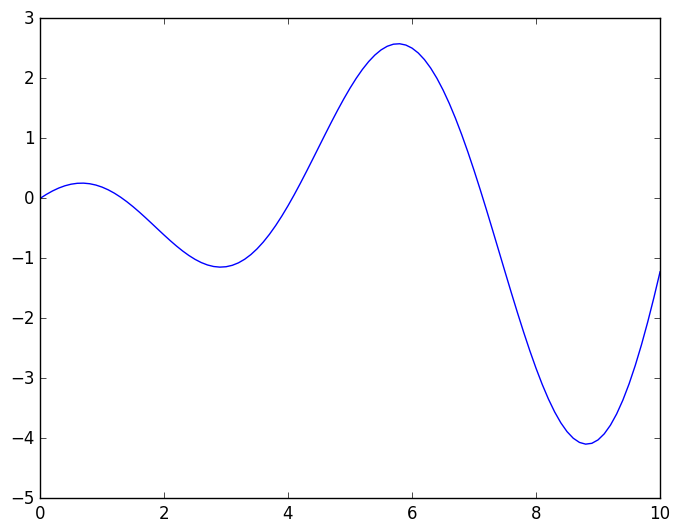

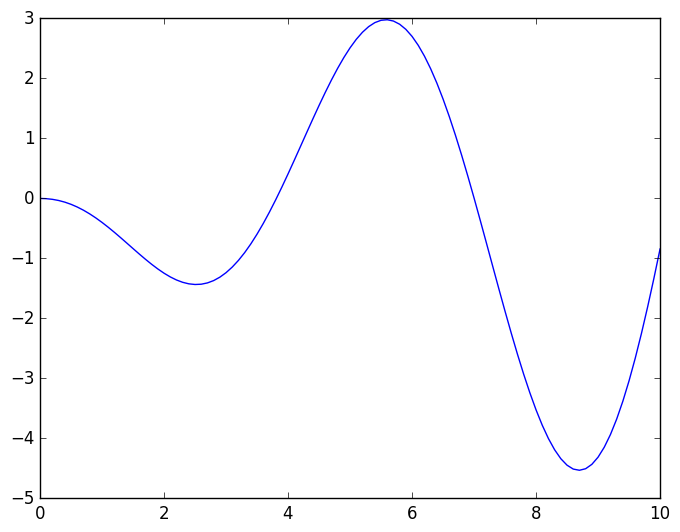

In [27]:
using Sundials

# Uncomment this to use QT interface for PyPlot
using PyCall
@pyimport(matplotlib)
pygui(:qt)
using PyPlot



# using the function f(t) = a*sin(b*t), f(0) = 0, we create an ODE by differentiating .

function rhs(t, y, ydot, p)
    y       = Sundials.asarray(y)
    ydot    = Sundials.asarray(ydot)
    p = unsafe_pointer_to_objref(p)
    
    ydot[1] = y[2] * p[1]
    ydot[2] = -y[1] * p[2]
    return Int32(0)
end

function runsens()
  (x, p)                    = ([0.7, 0.7], [1.0,1.0,1.0])          
  xdot                      = zeros(x)                    :: Array{Float64,1}
  t                         = collect(linspace(0,10,101)) :: Array{Float64,1}
  (reltol, abstol,sens_tol) = (1e-8, 1e-6, 1e-6)          :: Tuple{Float64,Float64, Float64}
  neq                       = length(x)
  NS                        = length(p)


  #######################################################################
  #                         ODE solver settings                         #
  #######################################################################
  
  #cvode_mem = Sundials.CVodeCreate(Sundials.CV_BDF, Sundials.CV_FUNCTIONAL)
  cvode_mem = Sundials.CVodeCreate(Sundials.CV_BDF, Sundials.CV_NEWTON)
  flag = Sundials.CVodeInit(cvode_mem,rhs, t[1], x)
  flag = Sundials.CVodeSetUserData(cvode_mem, p)
  flag = Sundials.CVodeSStolerances(cvode_mem, reltol, abstol)
  flag = Sundials.CVDense(cvode_mem, neq)


  # List of parameters for which to calculate sensitivities
  #plist = round(Int32,1:NS)

  # scaling of parameters
  pbar = copy(p)

  # Tolerances for solving sensitivities for each parameter
  #sens_tol_vec = [abstol :: Float64 for i in 1:NS]

  # IDEA: Maybe these should be scaled with parameter value?
  sens_tol_vec = [abstol*p[i] :: Float64 for i in 1:NS]

  # Sundials want a (pointer to a) vector where each component corresponds to 
  # a parameter, and where the element is a pointer to an array with a place for
  # each state variable. 
  ySJ    = Array(Array{Float64,1}, NS);
  for i in 1:NS
    ySJ[i] = zeros(Float64,neq)*1.0;
  end
  ySjulia = [Sundials.nvector(ySJ[i]) for i in 1:NS]
  yS = pointer(ySjulia)
  

  #######################################################################
  #                         Sensitivity settigs                         #
  #######################################################################
  
  sensi_meth = Sundials.CV_SIMULTANEOUS # CV_SIMULTANEOUS, CV_STAGGERED or CV_STAGGERED1
  flag = Sundials.CVodeSensInit1(cvode_mem, NS, sensi_meth, Ptr{Void}(0), yS);
  flag = Sundials.CVodeSensEEtolerances(cvode_mem);
  flag = Sundials.CVodeSetSensErrCon(cvode_mem, 0);
  #flag = Sundials.CVodeSensSStolerances(cvode_mem, reltol, sens_tol_vec);
  flag = Sundials.CVodeSetSensDQMethod(cvode_mem, Sundials.CV_CENTERED, 0.0);
  flag = Sundials.CVodeSetSensParams(cvode_mem, p, pbar, Ptr{Int32}(0));


  # Placeholder for solution and sensitivities
  solution = zeros(length(t), neq)
  solution[1,:] = copy(x)
  sens = zeros(length(t),neq,NS) # No need to copy initial condition, they are already zero

  tout = [t[1]] # Set first output time

  # Loop through all the output times
  for k in 2:length(t)
    # Extract the solution to x, and the sensitivities to yS
    flag = Sundials.CVode(cvode_mem, t[k], x, tout, Sundials.CV_NORMAL)
    flag = Sundials.CVodeGetSens(cvode_mem, tout, yS)

    #Save the results
    solution[k,:] = x
    for i in 1:NS
      sens[k,:,i] = Sundials.asarray(unsafe_load(yS,i))
    end
  end

  return (solution,sens)
end

#######################################################################
#                          Plot results                               #
#######################################################################
 
t = collect(linspace(0,10,101));

(solution, sens) = runsens()

figure(1)
plot(t,sens[:,1,1])

figure(2)
plot(t,sens[:,1,2])
show()

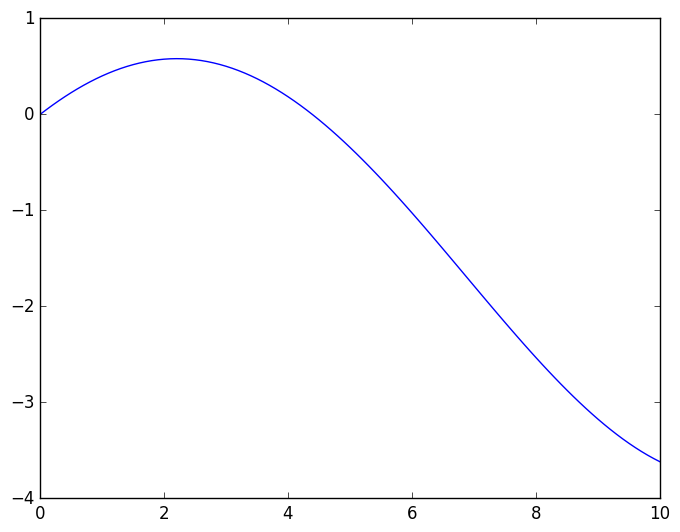

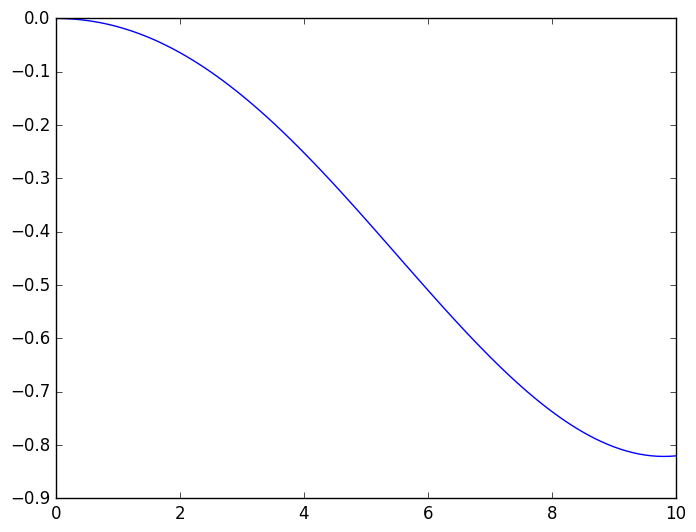

In [3]:
using Sundials

# Uncomment this to use QT interface for PyPlot
using PyCall
@pyimport(matplotlib)
pygui(:qt)
using PyPlot



# using the function f(t) = a*sin(b*t), f(0) = 0, we create an ODE by differentiating .

function cvodes(f, y0, p, ts; reltol=1e-8, abstol=1e-6)
  ydot = zeros(y0)
  neq  = length(y0)
  np = length(p)
  
  ### CVode settings ###
    
  cvode_mem = Sundials.CVodeCreate(Sundials.CV_BDF, Sundials.CV_NEWTON)
  flag = Sundials.CVodeInit(cvode_mem, rhs, t[1], y0)
  flag = Sundials.CVodeSetUserData(cvode_mem, p)
  flag = Sundials.CVodeSStolerances(cvode_mem, reltol, abstol)
  flag = Sundials.CVDense(cvode_mem, neq)
  
  ### Sensiviy Settings ###
  
  yS = [Sundials.nvector(zeros(Float64, neq)) for i in 1:np] |> pointer  
    
  flag = Sundials.CVodeSensInit1(cvode_mem, np, Sundials.CV_SIMULTANEOUS, Ptr{Void}(0), yS);
  flag = Sundials.CVodeSensEEtolerances(cvode_mem);
  flag = Sundials.CVodeSetSensErrCon(cvode_mem, 0);
  #flag = Sundials.CVodeSensSStolerances(cvode_mem, reltol, sens_tol_vec);
  flag = Sundials.CVodeSetSensDQMethod(cvode_mem, Sundials.CV_CENTERED, 0.0);
  flag = Sundials.CVodeSetSensParams(cvode_mem, p, p, Ptr{Int32}(0));


  # Placeholder for solution and sensitivities
  solution = zeros(length(t), neq)
  solution[1,:] = copy(y0)
  sens = zeros(length(t),neq,np) # No need to copy initial condition, they are already zero

  tout = [t[1]] # output time reached by the solver
  yout = copy(y0)

  # Loop through all the output times
  for k in 2:length(t)
    # Extract the solution to x, and the sensitivities to yS
    flag = Sundials.CVode(cvode_mem, t[k], yout, tout, Sundials.CV_NORMAL)
    flag = Sundials.CVodeGetSens(cvode_mem, tout, yS)

    #Save the results
    solution[k,:] = yout
    for i in 1:np
      sens[k,:,i] = Sundials.asarray(unsafe_load(yS,i))
    end
  end

  return (solution,sens)
end

#######################################################################
#                          Plot results                               #
#######################################################################

t = collect(linspace(0,10,101));

function rhs(t, y, ydot, p)
    y    = Sundials.asarray(y)
    ydot = Sundials.asarray(ydot)
    p    = unsafe_pointer_to_objref(p)
    f(t, y, ydot, p)
    return Int32(0)
end

function f(t, y, ydot, p)    
    ydot[1] =  y[2] * p[1]
    ydot[2] = -y[1] * p[2]
end

(solution, sens) = cvodes(f, [.3, .5], [.1, .6], t)

figure(1)
plot(t,sens[:,1,1])

figure(2)
plot(t,sens[:,1,2])
show()